In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [2]:
df = pd.read_csv('dataset/modeling_data.csv')

In [3]:
df_process = df.copy()

In [5]:
# selection des variables
selected_cols = ['age', 'housing', 'loan', 'duration', 'campaign', 'pdays', 'previous',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'contact_telephone', 'day_of_week_mon',
       'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed',
       'education_basic.9y', 'education_high.school',
       'education_professional.course', 'education_university.degree',
       'job_blue-collar', 'job_entrepreneur', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'marital_married', 'marital_single', 'month_jul', 'month_mar',
       'month_may', 'month_oct', 'poutcome_nonexistent', 'poutcome_success']

In [6]:
# separation des variables explicatives et variable cible

X = df_process[selected_cols]
y = df_process['y']

In [7]:
# Diviser les données en ensembles d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# remedier l'equilibre de classe par 'SMOTE' 

# Définir SMOTE et random forest
smote = SMOTE(random_state=42)
RF = RandomForestClassifier(bootstrap=True,
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=100,
    random_state=42) # d'apres gridsearch

# Créer un pipeline avec SMOTE et random_forest
pipeline = Pipeline([
    ('smote', smote),
    ('RF', RF)
])

# Entraîner le modèle
pipeline.fit(X_train, y_train)

# Prédire sur l'ensemble de test
y_pred = pipeline.predict(X_test)

# evaluation sur X_train
train_score = pipeline.score(X_train, y_train)
print("Train Score: ", train_score)

# evaluation sur X_test
test_score = pipeline.score(X_test, y_test)
print("Test Score: ", test_score)

# Afficher le rapport de classification
print(classification_report(y_test, y_pred))

Train Score:  0.8943533697632058
Test Score:  0.8736036911121904
              precision    recall  f1-score   support

           0       0.98      0.88      0.92      7265
           1       0.48      0.85      0.61       971

    accuracy                           0.87      8236
   macro avg       0.73      0.86      0.77      8236
weighted avg       0.92      0.87      0.89      8236



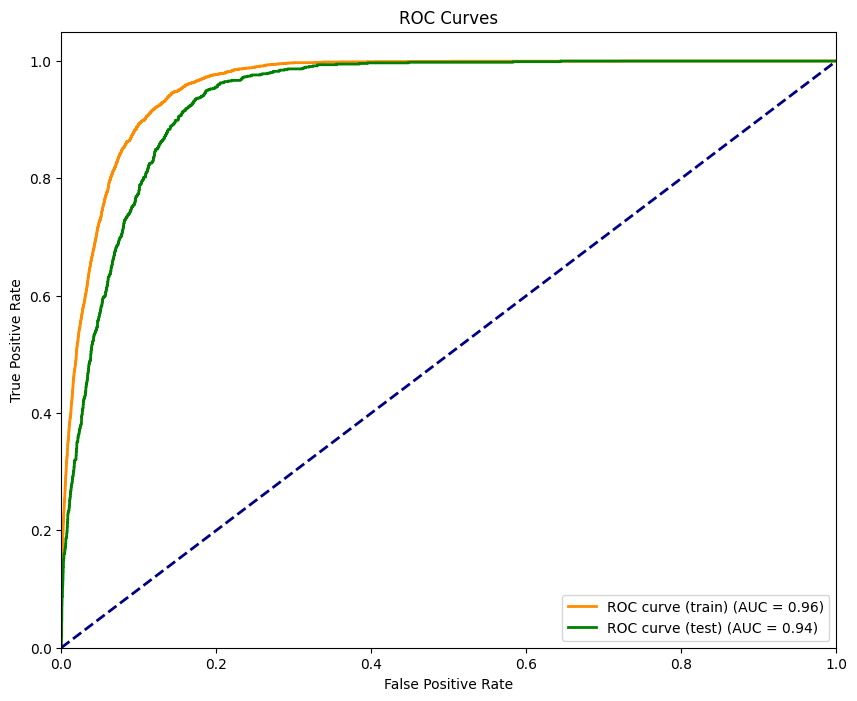

In [12]:
# Obtenir les probabilités pour la classe positive
y_train_proba = pipeline.predict_proba(X_train)[:, 1]
y_test_proba = pipeline.predict_proba(X_test)[:, 1]

# courbes ROC et l'AUC pour train et test
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
roc_auc_test = auc(fpr_test, tpr_test)

# Tracer les courbes ROC
plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve (train) (AUC = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='green', lw=2, label='ROC curve (test) (AUC = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

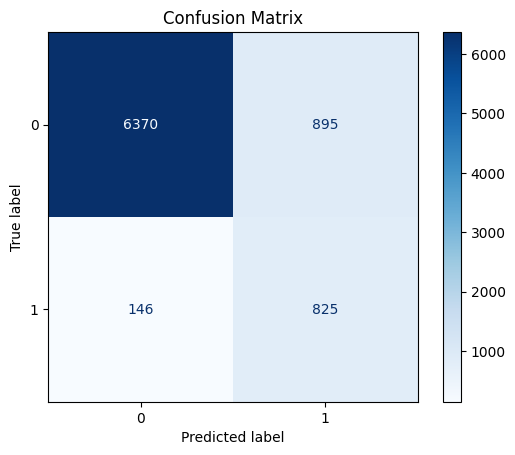

In [11]:
# matrice de de confusion 
cm = confusion_matrix(y_test, y_pred)

# Plot matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

C:\Users\RASAMISON Lovatiana\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


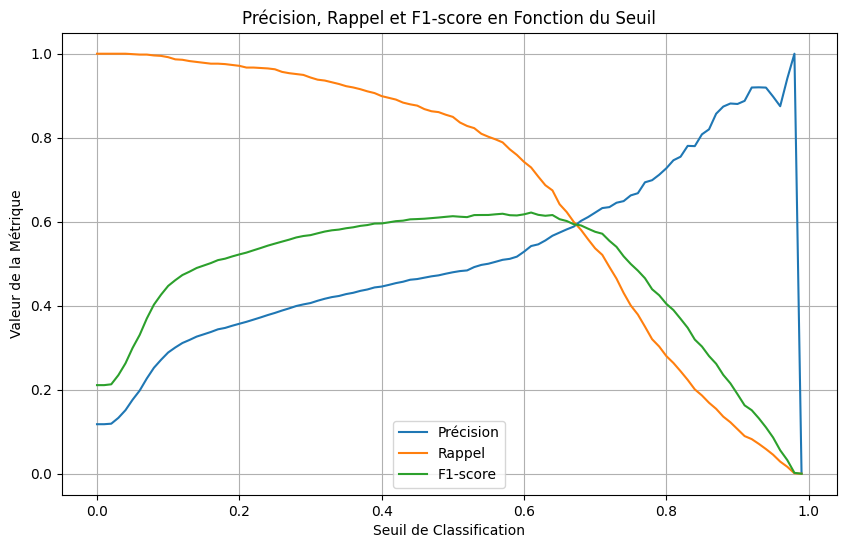

In [13]:
# Optimisation du seuil en maximisant le f1-score

thresholds = np.arange(0.0, 1.0, 0.01)

precisions = []
rappels = []
f1_scores = []

for i in thresholds:
    # Convertir les probabilités en prédictions binaires basées sur le seuil
    y_pred_thresholds = (y_test_proba >= i).astype(int)
    
    # Calculer les métriques
    precisions.append(precision_score(y_test, y_pred_thresholds))
    rappels.append(recall_score(y_test, y_pred_thresholds))
    f1_scores.append(f1_score(y_test, y_pred_thresholds))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Précision')
plt.plot(thresholds, rappels, label='Rappel')
plt.plot(thresholds, f1_scores, label='F1-score')
plt.xlabel('Seuil de Classification')
plt.ylabel('Valeur de la Métrique')
plt.title('Précision, Rappel et F1-score en Fonction du Seuil')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# F1-score maximal
indice_max_f1 = np.argmax(f1_scores)
threshold_optimal = thresholds[indice_max_f1]

# Générer les prédictions au seuil optimal
y_pred_optimal = (y_test_proba >= threshold_optimal).astype(int)

# evaluation sur X_test
test_score = pipeline.score(X_test, y_pred_optimal)
print("Test Score: ", test_score)

# Afficher le rapport de classification
print(classification_report(y_test, y_pred_optimal))


Test Score:  0.9497328800388538
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      7265
           1       0.54      0.73      0.62       971

    accuracy                           0.90      8236
   macro avg       0.75      0.82      0.78      8236
weighted avg       0.91      0.90      0.90      8236



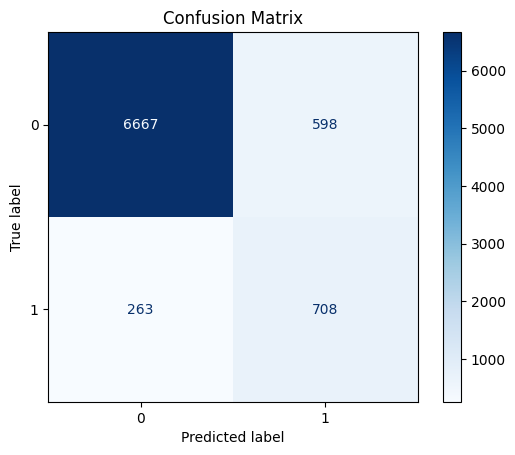

In [15]:
# matrice de de confusion 
cm = confusion_matrix(y_test, y_pred_optimal)

# Plot matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [16]:
# Obtenir l'importance des variables
rf_model = pipeline.named_steps['RF']
importance = rf_model.feature_importances_

# Créer un DataFrame pour afficher l'importance des variables
importance_df = pd.DataFrame({'Variable': X.columns, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Afficher l'importance des variables
print("Importance des variables :")
print(importance_df)
print()

Importance des variables :
                         Variable  Importance
0                        duration    0.425562
1                     nr.employed    0.133005
2                       euribor3m    0.107354
3                    emp.var.rate    0.067543
4                   cons.conf.idx    0.042108
5                        campaign    0.031768
6                  cons.price.idx    0.028701
7               contact_telephone    0.027284
8                           pdays    0.021658
9                poutcome_success    0.020276
10                      month_may    0.016910
11                       previous    0.014327
12                            age    0.008500
13           poutcome_nonexistent    0.008003
14                      month_oct    0.006980
15                      month_mar    0.006169
16                      month_jul    0.003259
17                job_blue-collar    0.002698
18                day_of_week_mon    0.002675
19    education_university.degree    0.002451
20     

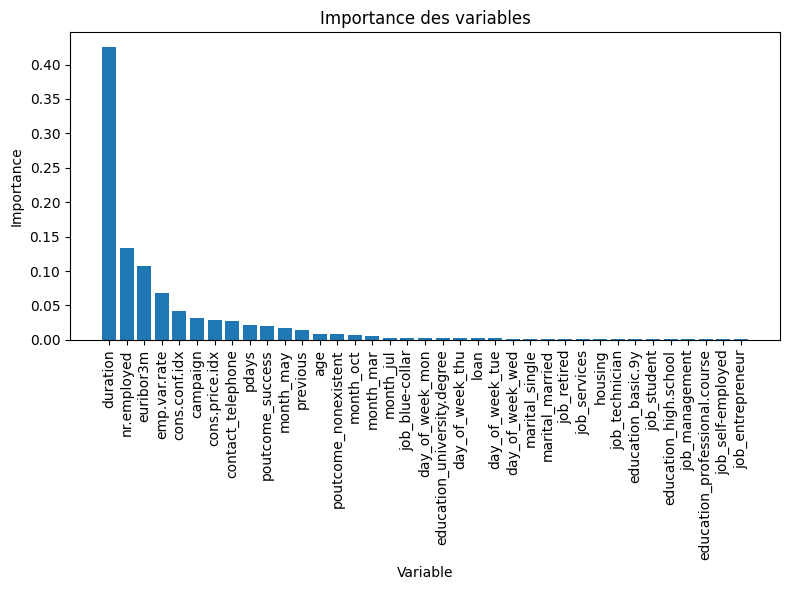

In [17]:
# Tracer l'importance des variables
plt.figure(figsize=(8, 6))
plt.bar(importance_df['Variable'], importance_df['Importance'])
plt.xticks(rotation='vertical')
plt.xlabel('Variable')
plt.ylabel('Importance')
plt.title('Importance des variables')
plt.tight_layout()
plt.show()